In [1]:
import os
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from scipy.misc import imresize
from scipy import ndimage

%matplotlib inline

import tensorflow as tf
from keras.layers import Dense, Activation, Flatten, Lambda, BatchNormalization, Reshape, Dropout
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.engine import merge, Input, Model
from keras.optimizers import SGD
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
import time
import random
import pickle
import json
import csv
from tqdm import tqdm
from natsort import natsorted

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from helper import to_rle
from segmentation import *
from stochastic_depth_resnet import *

DATADIR = os.path.expanduser('~/data/kaggle/ultrasound-nerve-segmentation')
PROCDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/processed')
MODELDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/models')
SUBMITDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/submissions')

Using TensorFlow backend.


In [2]:
WEIGHTS_PRESENCE_FILEPATH = os.path.join(MODELDIR, 'model-06-presence-weights.hdf5')
HISTORY_PRESENCE_FILEPATH = os.path.join(MODELDIR, 'model-06-presence-training-history.json')

WEIGHTS_SEGMENT_FILEPATH = os.path.join(MODELDIR, 'model-06-segment-weights.hdf5')
HISTORY_SEGMENT_FILEPATH = os.path.join(MODELDIR, 'model-06-segment-training-history.json')

In [3]:
with open(os.path.join(PROCDIR, 'train_files_map.pkl'), 'rb') as f:
    train_files_map = pickle.load(f)
with open(os.path.join(PROCDIR, 'test_files_map.pkl'), 'rb') as f:
    test_files_map = pickle.load(f)

In [4]:
with open(os.path.join(PROCDIR, 'data_train_val_06.pkl'), 'rb') as f:
    (data_images_train, data_images_val, 
     data_presence_train, data_presence_val, 
     data_masks_train, data_masks_val) = pickle.load(f)

print('image shapes:', data_images_train.shape, data_images_val.shape)
print('presence label shapes:', data_presence_train.shape, data_presence_val.shape)
print('mask shapes:', data_masks_train.shape, data_masks_val.shape)

image shapes: (10312, 256, 384, 1) (479, 256, 384, 1)
presence label shapes: (10312,) (479,)
mask shapes: (10312, 256, 384) (479, 256, 384)


## presence model

In [16]:
with tf.device('/gpu:0'):
    
    start_time = time.time()

    orig_img_rows, orig_img_cols = 420, 580
    img_rows, img_cols = 256, 384
    img_channels = 1

    blocks_per_group = 3
    nb_total_blocks = 5 * blocks_per_group
    
    images_presence = Input(shape=(img_rows, img_cols, img_channels))

    x = Convolution2D(8, 3, 3, subsample=(2, 2),
                      init='he_normal', border_mode='same', dim_ordering='tf')(images_presence)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    for i in range(0, blocks_per_group):
        nb_filters = 8
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    for i in range(0, blocks_per_group):
        nb_filters = 16
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    for i in range(0, blocks_per_group):
        nb_filters = 32
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=2 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    for i in range(0, blocks_per_group):
        nb_filters = 64
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=3 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    for i in range(0, blocks_per_group):
        nb_filters = 128
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=4 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    x = AveragePooling2D(pool_size=(4, 4), strides=None, border_mode='valid', dim_ordering='tf')(x)
    x = Flatten()(x)
    presence = Dense(1, activation='sigmoid')(x)

    model_presence = Model(input=images_presence, output=presence)

    print('model init time: {}'.format(time.time() - start_time))

    start_time = time.time()

    model_presence.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print('model compile time: {}'.format(time.time() - start_time))

model init time: 11.669359683990479
model compile time: 2.3051598072052


## presence model train

In [10]:
with tf.device('/gpu:0'):
    
    batch_size = 128
    nb_epoch = 3

    # Model saving callback
    #checkpointer = ModelCheckpoint(filepath=WEIGHTS_PRESENCE_FILEPATH, verbose=1, save_best_only=True)

    # Early stopping
    #early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    history = model_presence.fit(data_images_train, data_presence_train,
                                 batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                                 validation_data=(data_images_val, data_presence_val), shuffle=True,
                                 callbacks=[])

    #with open(HISTORY_PRESENCE_FILEPATH, 'w') as f_out:
    #    json.dump(history.history, f_out)

Train on 10312 samples, validate on 479 samples
Epoch 1/3
10312/10312 [==============================] - 45s - loss: 0.9883 - acc: 0.5659 - val_loss: 0.6345 - val_acc: 0.6221
Epoch 2/3
10312/10312 [==============================] - 43s - loss: 0.6698 - acc: 0.6175 - val_loss: 0.5708 - val_acc: 0.7620
Epoch 3/3
10312/10312 [==============================] - 43s - loss: 0.6330 - acc: 0.6580 - val_loss: 0.5296 - val_acc: 0.7537


## segmentation model

In [5]:
with tf.device('/gpu:1'):
    
    start_time = time.time()

    orig_img_rows, orig_img_cols = 420, 580
    img_rows, img_cols = 256, 384
    img_channels = 1

    blocks_per_group = 3
    nb_total_blocks = 5 * blocks_per_group

    images_segment = Input(shape=(img_rows, img_cols, img_channels))

    x = Convolution2D(8, 3, 3, subsample=(2, 2),
                      init='he_normal', border_mode='same', dim_ordering='tf')(images_segment)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    for i in range(0, blocks_per_group):
        nb_filters = 8
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f4 = x
    f4 = UpSampling2D(size=(4, 4), dim_ordering='tf')(f4)
    f4 = Convolution2D(8, 3, 3, init='he_normal', border_mode='same', activation='relu', dim_ordering='tf')(f4)

    for i in range(0, blocks_per_group):
        nb_filters = 16
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f8 = x
    f8 = UpSampling2D(size=(8, 8), dim_ordering='tf')(f8)
    f8 = Convolution2D(8, 3, 3, init='he_normal', border_mode='same', activation='relu', dim_ordering='tf')(f8)

    for i in range(0, blocks_per_group):
        nb_filters = 32
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=2 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f16 = x
    f16 = UpSampling2D(size=(16, 16), dim_ordering='tf')(f16)
    f16 = Convolution2D(8, 3, 3, init='he_normal', border_mode='same', activation='relu', dim_ordering='tf')(f16)

    for i in range(0, blocks_per_group):
        nb_filters = 64
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=3 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f32 = x
    f32 = UpSampling2D(size=(32, 32), dim_ordering='tf')(f32)
    f32 = Convolution2D(8, 3, 3, init='he_normal', border_mode='same', activation='relu', dim_ordering='tf')(f32)

    for i in range(0, blocks_per_group):
        nb_filters = 128
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=4 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f64 = x
    f64 = UpSampling2D(size=(64, 64), dim_ordering='tf')(f64)
    f64 = Convolution2D(8, 3, 3, init='he_normal', border_mode='same', activation='relu', dim_ordering='tf')(f64)

    segmentation = merge([f64, f32, f16, f8, f4], mode='concat', concat_axis=-1)
    segmentation = Convolution2D(1, 1, 1,
                                 activation='sigmoid',
                                 init='uniform', border_mode='same', dim_ordering='tf')(segmentation)
    segmentation = Reshape((img_rows, img_cols))(segmentation)

    model_segment = Model(input=images_segment, output=segmentation)

    print('model init time: {}'.format(time.time() - start_time))

    start_time = time.time()

    model_segment.compile(optimizer='adam', loss=binaryCE, metrics=[dice_coeff])

    print('model compile time: {}'.format(time.time() - start_time))

model init time: 5.501148700714111
model compile time: 2.194781541824341


## segmentation model train

In [ ]:
with tf.device('/gpu:1'):
    
    batch_size = 32
    nb_epoch = 3

    # Model saving callback
    #checkpointer = ModelCheckpoint(filepath=WEIGHTS_PRESENCE_FILEPATH, verbose=1, save_best_only=True)

    # Early stopping
    #early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    history = model_segment.fit(data_images_train, data_masks_train,
                                batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                                validation_data=(data_images_val, data_masks_val), shuffle=True,
                                callbacks=[])

    #with open(HISTORY_PRESENCE_FILEPATH, 'w') as f_out:
    #    json.dump(history.history, f_out)

## test

In [17]:
with tf.device('/gpu:0'):
    model_presence.load_weights(WEIGHTS_PRESENCE_FILEPATH)

In [6]:
with tf.device('/gpu:1'):
    model_segment.load_weights(WEIGHTS_SEGMENT_FILEPATH)

presence prediction:  [ 0.8342157] [ True]


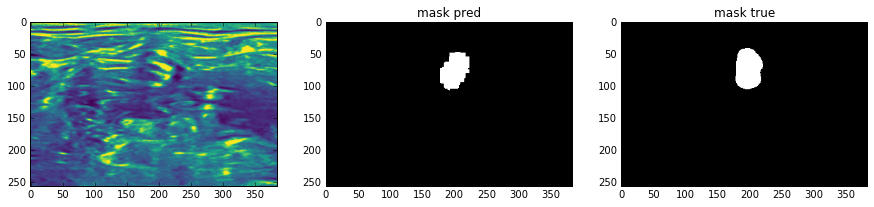

In [19]:
rand_i = random.randint(0, data_images_val.shape[0] - 1)

presence = model_presence.predict(data_images_val[rand_i:rand_i+1], verbose=0)[0]
print('presence prediction: ', presence, presence > 0.5)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(data_images_val[rand_i, :, :, 0], cmap=plt.cm.viridis)
plt.subplot(1,3,2)
plt.title('mask pred')
plt.imshow(model_segment.predict(data_images_val[rand_i:rand_i+1], verbose=0)[0, :, :] > 0.5, cmap=plt.cm.bone)
plt.subplot(1,3,3)
plt.title('mask true')
plt.imshow(data_masks_val[rand_i, :, :], cmap=plt.cm.bone)

In [20]:
preds_segment = model_segment.predict(data_images_val, verbose=0)
np.mean(2 * np.sum(data_masks_val * preds_segment>0.5) / (np.sum(data_masks_val) + np.sum(preds_segment>0.5) + 1e-6), axis=None)

0.65881635711153552

In [21]:
preds_mod = []
for i in range(preds_segment.shape[0]):
    preds_mod.append(ndimage.morphology.binary_fill_holes(preds_segment[i,:,:]>0.5))
preds_mod = np.array(preds_mod, dtype=np.bool)
np.mean(2 * np.sum(data_masks_val * preds_mod) / (np.sum(data_masks_val) + np.sum(preds_mod) + 1e-6), axis=None)

0.65914962386672826

In [60]:
preds_presence = model_presence.predict(data_images_val, verbose=0)
preds_segment = model_segment.predict(data_images_val, verbose=0)
preds_mod = []
for i in range(preds_segment.shape[0]):
    if preds_presence[i] < 0.21:
        preds_mod.append(preds_segment[i,:,:]>0.8)
    elif preds_presence[i] > 0.7:
        preds_mod.append(preds_segment[i,:,:]>0.3)
    else:
        preds_mod.append(preds_segment[i,:,:]>0.5)
np.mean(2 * np.sum(data_masks_val * preds_mod) / (np.sum(data_masks_val) + np.sum(preds_mod) + 1e-6), axis=None)

0.69023982951455809

In [61]:
with open(os.path.join(SUBMITDIR, 'model-06.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['img', 'pixels'])

    for key in tqdm(natsorted(list(test_files_map.keys()))):
        file_info = test_files_map[key]
        img, folder, img_file = file_info['img'], file_info['folder'], file_info['img_file']
        img_filepath = os.path.join(folder, img_file)
        image = io.imread(img_filepath) / 255.0
        image_resized = np.expand_dims(imresize(image, size=(img_rows, img_cols), interp='bilinear'), axis=3)
        presence = model_presence.predict(np.array([image_resized], dtype=np.float32), verbose=0)[0]
        mask_pred = model_segment.predict(np.array([image_resized], dtype=np.float32), verbose=0)
        if presence < 0.21:
            mask_pred = mask_pred[0, :, :] > 0.8
        elif presence > 0.7:
            mask_pred = mask_pred[0, :, :] > 0.3
        else:
            mask_pred = mask_pred[0, :, :] > 0.5
        mask_pred_orig_size = imresize(mask_pred, size=(orig_img_rows, orig_img_cols), interp='bilinear').astype(np.bool)
        rle = to_rle(mask_pred_orig_size)
        writer.writerow([img, rle])

 11%|█         | 596/5508 [00:47<05:24, 15.13it/s]/home/leon/install/miniconda3/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
100%|██████████| 5508/5508 [07:24<00:00, 14.22it/s]
